# Install and Import Dependencies

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import warnings

from scipy.stats import ttest_ind, pearsonr, spearmanr, shapiro

from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)
warnings.filterwarnings('ignore')
%matplotlib inline

# Load data

In [2]:
df = pd.read_csv('../housing-sales-king-county/dataset/data.csv', sep=',')
df.shape

(1845, 16)

# Descriptive Analysis

In [3]:
df.head()

,price,num_bed,num_bath,size_house,size_lot,num_floors,is_waterfront,condition,size_basement,year_built,renovation_date,zip,latitude,longitude,avg_size_neighbor_houses,avg_size_neighbor_lot
0,239000,3,1.0,1510,15022,1.0,0,3,0,1962,0,98003,47.330433,-122.303609,1510,12970
1,1260000,3,3.5,3220,3960,2.0,0,3,460,1991,0,98116,47.590933,-122.384230,3080,4444
2,414500,3,1.0,1050,6002,1.0,0,3,210,1941,0,98115,47.698761,-122.316010,1180,6003
3,252500,3,2.5,1780,7192,1.0,0,4,530,1974,0,98031,47.409319,-122.173484,1870,8500
4,389000,3,1.0,1330,3740,1.5,0,3,0,1903,0,98118,47.550242,-122.274232,1330,5053


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1845 entries, 0 to 1844
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   price                     1845 non-null   int64  
 1   num_bed                   1845 non-null   int64  
 2   num_bath                  1845 non-null   float64
 3   size_house                1845 non-null   int64  
 4   size_lot                  1845 non-null   int64  
 5   num_floors                1845 non-null   float64
 6   is_waterfront             1845 non-null   int64  
 7   condition                 1845 non-null   int64  
 8   size_basement             1845 non-null   int64  
 9   year_built                1845 non-null   int64  
 10  renovation_date           1845 non-null   int64  
 11  zip                       1845 non-null   int64  
 12  latitude                  1845 non-null   float64
 13  longitude                 1845 non-null   float64
 14  avg_size

# NaN analysis

It was possible to notice with the code line above that there are no null values in the dataframe. Just to make sure, it will be verified below.

In [5]:
df.isnull().sum()

price                       0
num_bed                     0
num_bath                    0
size_house                  0
size_lot                    0
num_floors                  0
is_waterfront               0
condition                   0
size_basement               0
year_built                  0
renovation_date             0
zip                         0
latitude                    0
longitude                   0
avg_size_neighbor_houses    0
avg_size_neighbor_lot       0
dtype: int64

# Duplicated values

In [6]:
print('Total of duplicated values:', df[df.duplicated()].shape[0])

Total of duplicated values: 0


# Exploratory Data Analysis (EDA)

## Histograms of dataframe

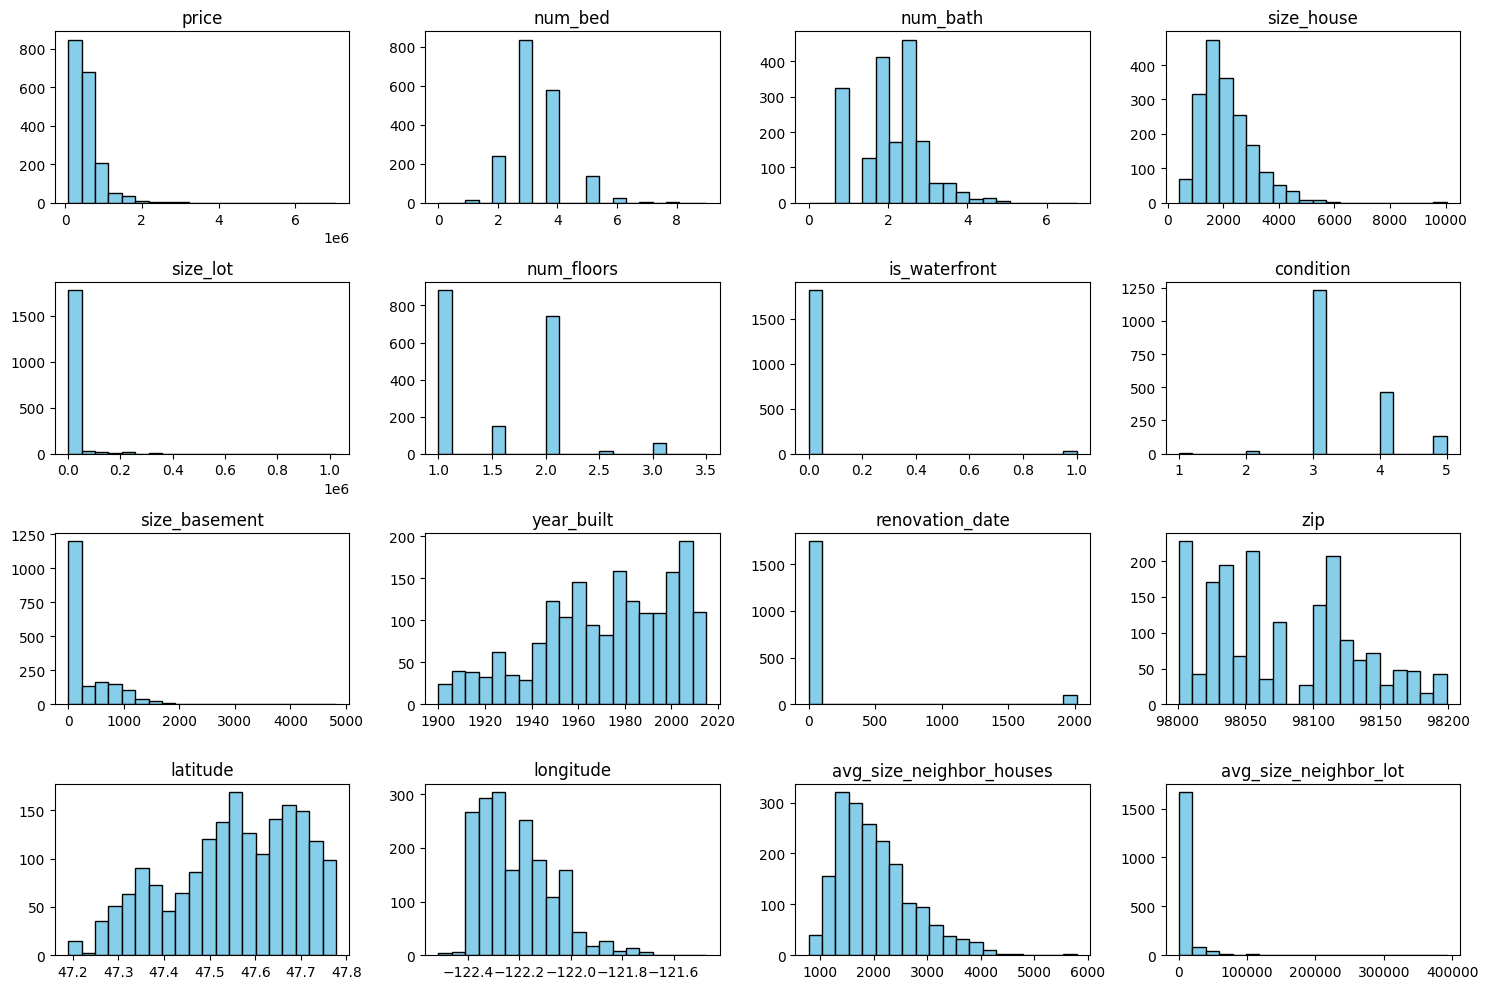

In [7]:
df.hist(figsize=(15,10), color='skyblue', edgecolor='black', bins=20, grid=False)
plt.tight_layout()
plt.show()

## Waterfront

In [8]:
round(df['is_waterfront'].value_counts(normalize=True) * 100,2)

0    98.59
1     1.41
Name: is_waterfront, dtype: float64

Only 1,41% of houses sold has a view to a waterfront

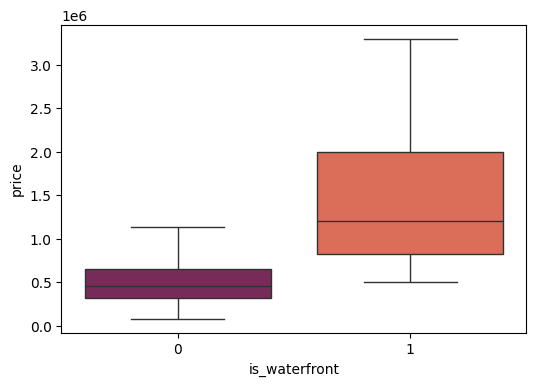

In [9]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='is_waterfront', y='price', showfliers=False, palette="rocket")
plt.show()

### Student's T-test

Student's T-test for mean comparison

* Null Hypothesis (H0): There is no significant difference between the means.

* Alternative Hypothesis (H1): There is a significant difference between the means.

* p-value: expresses the risk of rejecting the null hypothesis when it is true.

* alpha (significance level): the maximum risk we are willing to assume in committing the Type I error (rejecting H0 when it is true).

In [10]:
is_waterfront_true_price = df[df['is_waterfront'].eq(1)]['price']
is_waterfront_false_price = df[df['is_waterfront'].eq(0)]['price']

In [11]:
stat, p = ttest_ind(is_waterfront_true_price, is_waterfront_false_price)

print('P-value: ', p)

if p > 0.05:
    print('There is no significant difference between the means.')
else:
    print('There is a significant difference between the means.')

P-value:  4.02713724854198e-53
There is a significant difference between the means.


## Renovation date

In [12]:
round(df['renovation_date'].value_counts(normalize=True) * 100,2).head(8)

0       94.58
2014     0.60
2003     0.33
2000     0.27
1985     0.27
2002     0.22
2013     0.22
1984     0.16
Name: renovation_date, dtype: float64

In [13]:
print('Year of the oldest renovation:', df[~df['renovation_date'].eq(0)]['renovation_date'].min())
print('Year of the newest renovation:', df[~df['renovation_date'].eq(0)]['renovation_date'].max())

Year of the oldest renovation: 1948
Year of the newest renovation: 2014


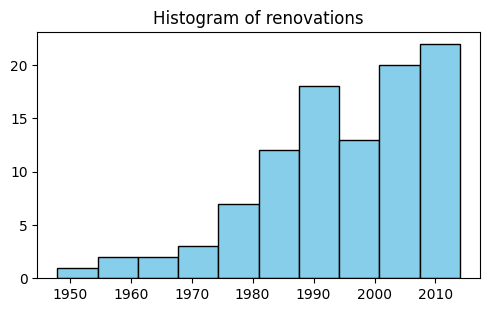

In [14]:
df[~df['renovation_date'].eq(0)]['renovation_date'].hist(figsize=(5,3), color='skyblue', edgecolor='black', grid=False)
plt.tight_layout()
plt.title('Histogram of renovations')
plt.show()

94.58% of the houses sold have never been renovated. Renovated houses represents 5.42% and the years range from 1948 to 2014.

## Number of floors

In [15]:
round(df['num_floors'].value_counts(normalize=True) * 100,2)

1.0    47.80
2.0    40.16
1.5     7.97
3.0     3.20
2.5     0.81
3.5     0.05
Name: num_floors, dtype: float64

Since there are decimal values for the num_floors feature, I will assume that these are penthouse apartments.

PENTHOUSE meaning: 1. an expensive apartment or set of rooms at the top of a hotel or tall building. Font: Cambridge Dictionary

## Condition

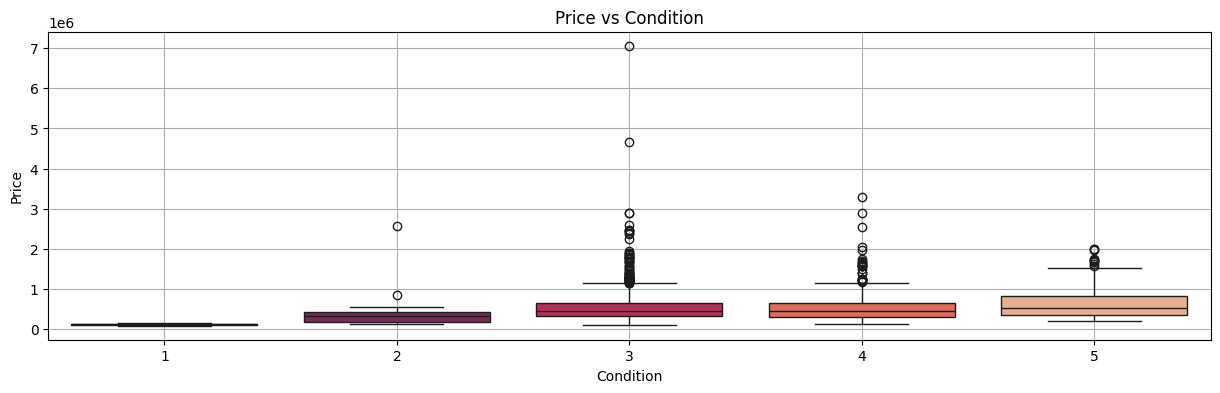

In [16]:
plt.figure(figsize=(15, 4))
sns.boxplot(x='condition', y='price', data=df, palette='rocket')
plt.title('Price vs Condition')
plt.xlabel('Condition')
plt.ylabel('Price')
plt.grid(True)
plt.show()

Condition is not necessarily the determinant of how expensive the house will be.

## Size House

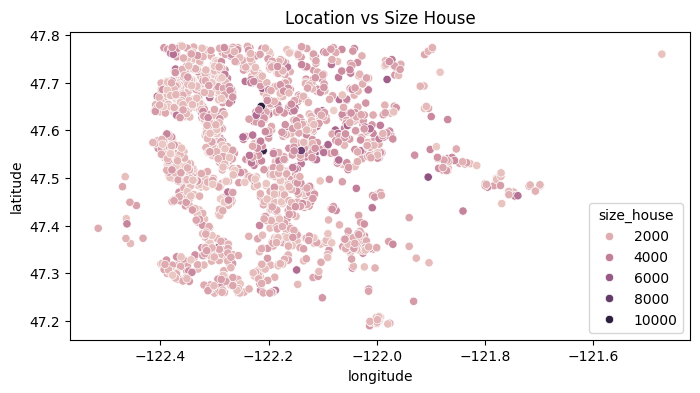

In [17]:
plt.figure(figsize=(8,4))
sns.scatterplot(x=df['longitude'], y=df['latitude'], hue=df['size_house'])
plt.title('Location vs Size House')
plt.show()

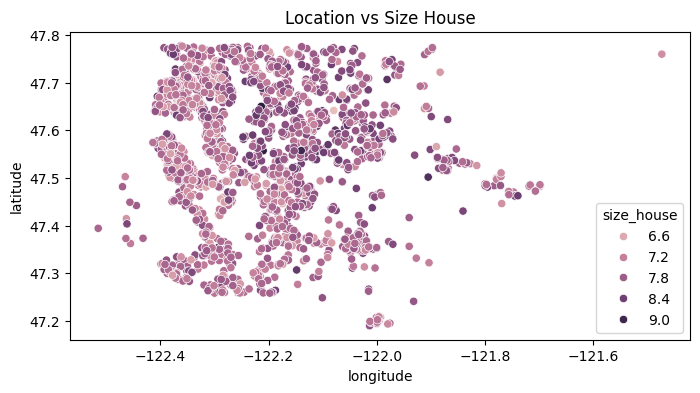

In [18]:
plt.figure(figsize=(8,4))
sns.scatterplot(x=df['longitude'], y=df['latitude'], hue=np.log(df['size_house']))
plt.title('Location vs Size House')
plt.show()

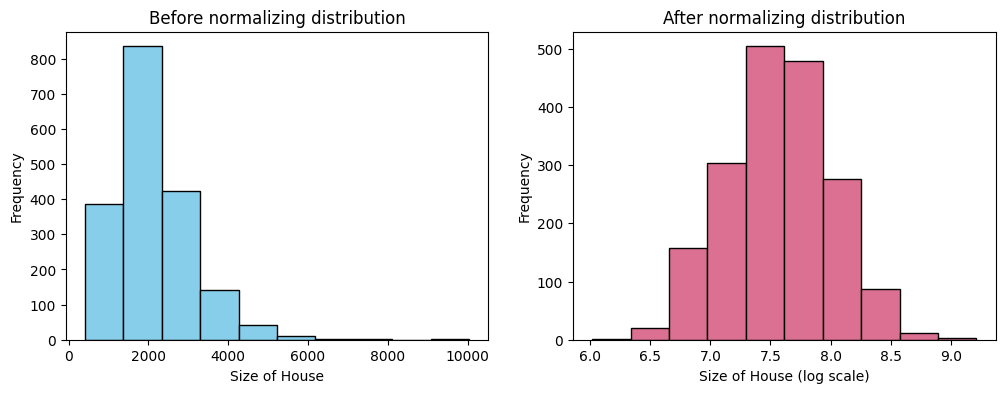

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

df['size_house'].plot(kind='hist', ax=axs[0], color='skyblue', edgecolor='black')
axs[0].set_title('Before normalizing distribution')
axs[0].set_xlabel('Size of House')

np.log(df['size_house']).plot(kind='hist', ax=axs[1], color='palevioletred', edgecolor='black')
axs[1].set_title('After normalizing distribution')
axs[1].set_xlabel('Size of House (log scale)')

plt.show()

Larger houses seems to be more located towards the center/north, coinciding with the size information.

In [20]:
f = folium.Figure(width=1200, height=600)
map = folium.Map(location= [47.518518, -122.224414], tiles="cartodbpositron",
                    zoom_start=10, min_zoom = 6).add_to(f)

heat_data = [[row['latitude'], row['longitude']] for index, row in df.iterrows()]
HeatMap(heat_data, name='Heat Map', min_opacity=0.2, max_val=df['price'].max(), radius=25, blur=15).add_to(map)

max_price_index = df['price'].idxmax()
max_price_location = [df.loc[max_price_index, 'latitude'], df.loc[max_price_index, 'longitude']]
folium.Marker(max_price_location, popup=f'Highest Price: ${df.loc[max_price_index, "price"]}',
              icon=folium.Icon(color='red', icon='info-sign')).add_to(map)

min_price_index = df['price'].idxmin()
min_price_location = [df.loc[min_price_index, 'latitude'], df.loc[min_price_index, 'longitude']]
popup_content_min = f'Lowest Price: ${df.loc[min_price_index, "price"]}'
folium.Marker(min_price_location, popup=popup_content_min,
              icon=folium.Icon(color='blue', icon='info-sign')).add_to(map)

folium.TileLayer('openstreetmap').add_to(map)
folium.TileLayer('cartodbpositron').add_to(map)
folium.LayerControl(collapsed=False).add_to(map)

map

To iteract with the dynamic map, please check this notebook at https://nbviewer.org/github/guilhermegarcia-ai/ml-regression-models/blob/main/housing-sales-king-county/housing_sales_regression.ipynb.

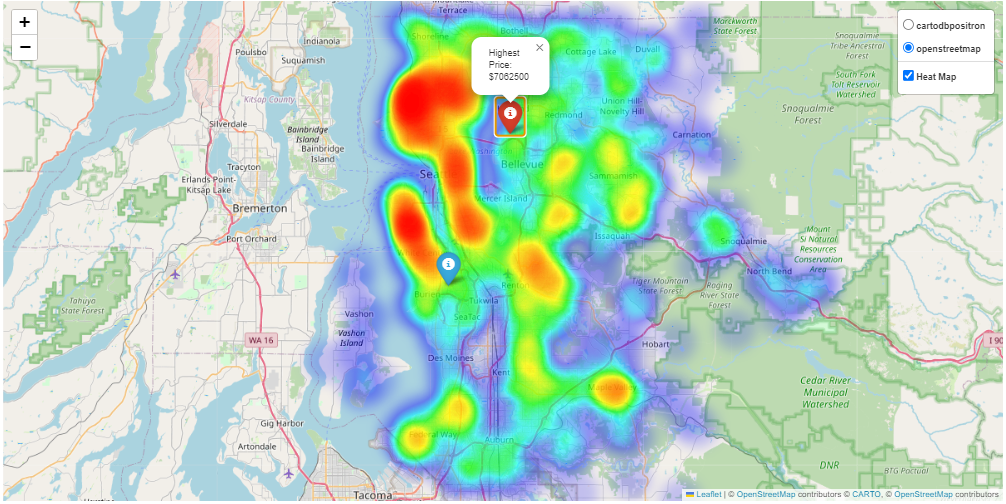

## Correlation

In [21]:
#Pearson

feature_list = []
corr_pearson = []
pvalue_pearson = []

for col in df.columns:
    feature_list.append(col)
    cor, p = pearsonr(df[col], df['price'])

    corr_pearson.append(np.round(cor,2))
    pvalue_pearson.append(np.round(p,2))

#Spearman

corr_spearman = []
pvalue_spearman = []

for col in df.columns:
    cor, p = spearmanr(df[col], df['price'])
    
    corr_spearman.append(np.round(cor,2))
    pvalue_spearman.append(np.round(p,2))

In [22]:
df_corr = pd.DataFrame({'feature':feature_list,
                        'corr_pearson': corr_pearson,
                        'pvalue_pearson': pvalue_pearson,
                        'corr_spearman': corr_spearman,
                        'pvalue_spearman': pvalue_spearman})

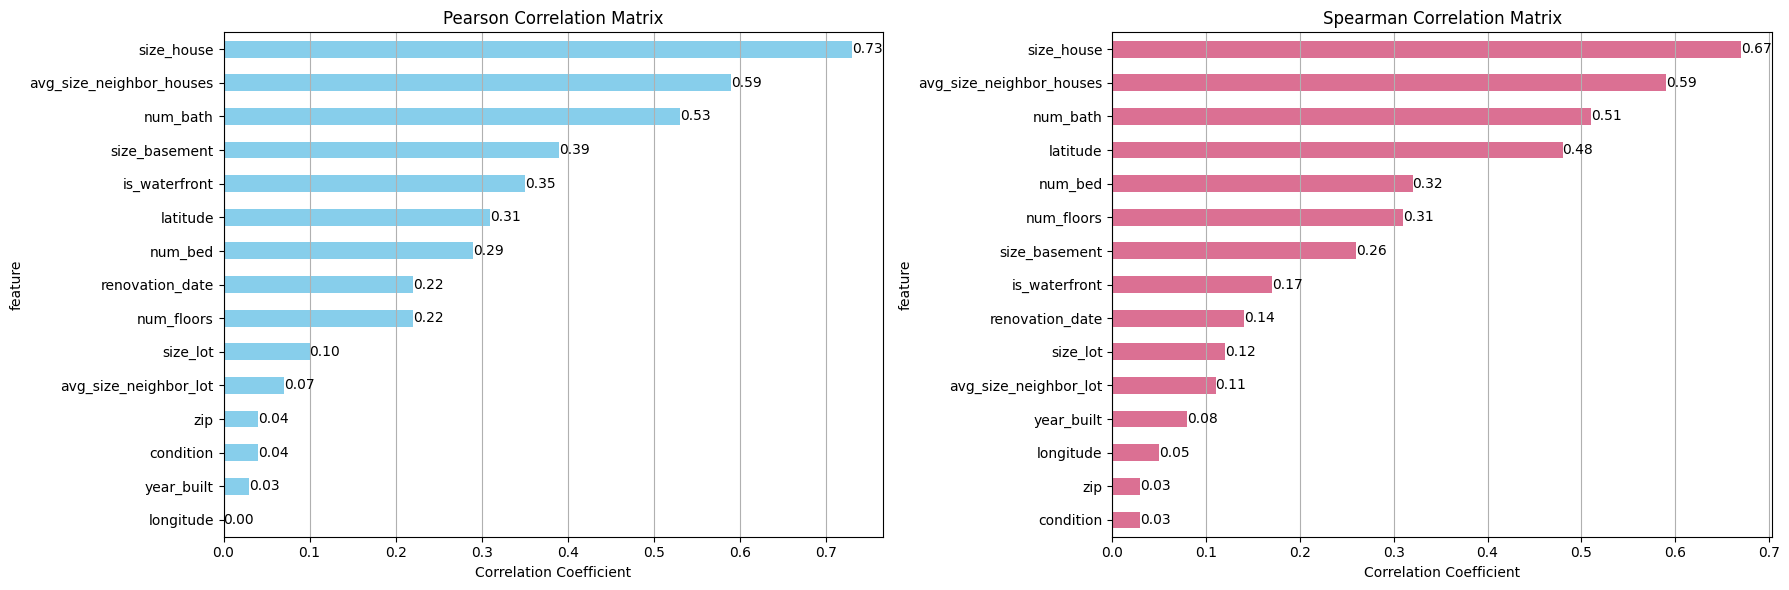

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Pearson Correlation
df_pearson_corr = df_corr[['feature','corr_pearson']][~df_corr['feature'].eq('price')]
df_pearson_corr['corr_pearson'] = df_pearson_corr['corr_pearson'].abs()

df_pearson_corr.set_index('feature')['corr_pearson'].sort_values().plot(kind='barh', color='skyblue', ax=axs[0])
axs[0].grid(axis='x')
axs[0].set_title('Pearson Correlation Matrix')
axs[0].set_xlabel('Correlation Coefficient')

for index, value in enumerate(df_pearson_corr['corr_pearson'].sort_values()):
    axs[0].annotate(f'{value:.2f}', xy=(value, index), va='center')

# Spearman Correlation
df_spearman_corr = df_corr[['feature','corr_spearman']][~df_corr['feature'].eq('price')]
df_spearman_corr['corr_spearman'] = df_spearman_corr['corr_spearman'].abs()

df_spearman_corr.set_index('feature')['corr_spearman'].sort_values().plot(kind='barh', color='palevioletred', ax=axs[1])
axs[1].grid(axis='x')
axs[1].set_title('Spearman Correlation Matrix')
axs[1].set_xlabel('Correlation Coefficient')

for index, value in enumerate(df_spearman_corr['corr_spearman'].sort_values()):
    axs[1].annotate(f'{value:.2f}', xy=(value, index), va='center')

plt.tight_layout()
plt.show()

In [24]:
df_corr

,feature,corr_pearson,pvalue_pearson,corr_spearman,pvalue_spearman
0,price,1.00,0.00,1.00,0.00
1,num_bed,0.29,0.00,0.32,0.00
2,num_bath,0.53,0.00,0.51,0.00
3,size_house,0.73,0.00,0.67,0.00
4,size_lot,0.10,0.00,0.12,0.00
5,num_floors,0.22,0.00,0.31,0.00
6,is_waterfront,0.35,0.00,0.17,0.00
7,condition,0.04,0.08,0.03,0.26
8,size_basement,0.39,0.00,0.26,0.00
9,year_built,0.03,0.14,0.08,0.00


In the correlation test:
* H0: There is no significant correlation > 0
* H1: There is a significant correlation > 0

Therefore:
* p-value < 0.05 indicates that we can reject H0 and assume there is a correlation > 0
* p-value > 0.05 indicates that there is no correlation > 0

### Removing features with p-value > 0.05 for Pearson correlation, indicating no significant correlation.

In [25]:
remaining_features = df_corr.loc[df_corr['pvalue_pearson'] <= 0.05]['feature'].tolist()

print(f'Features deleted:', df_corr.loc[df_corr['pvalue_pearson'] > 0.05]['feature'].tolist())
print(f'Remaining features:', remaining_features)

Features deleted: ['condition', 'year_built', 'zip', 'longitude']
Remaining features: ['price', 'num_bed', 'num_bath', 'size_house', 'size_lot', 'num_floors', 'is_waterfront', 'size_basement', 'renovation_date', 'latitude', 'avg_size_neighbor_houses', 'avg_size_neighbor_lot']


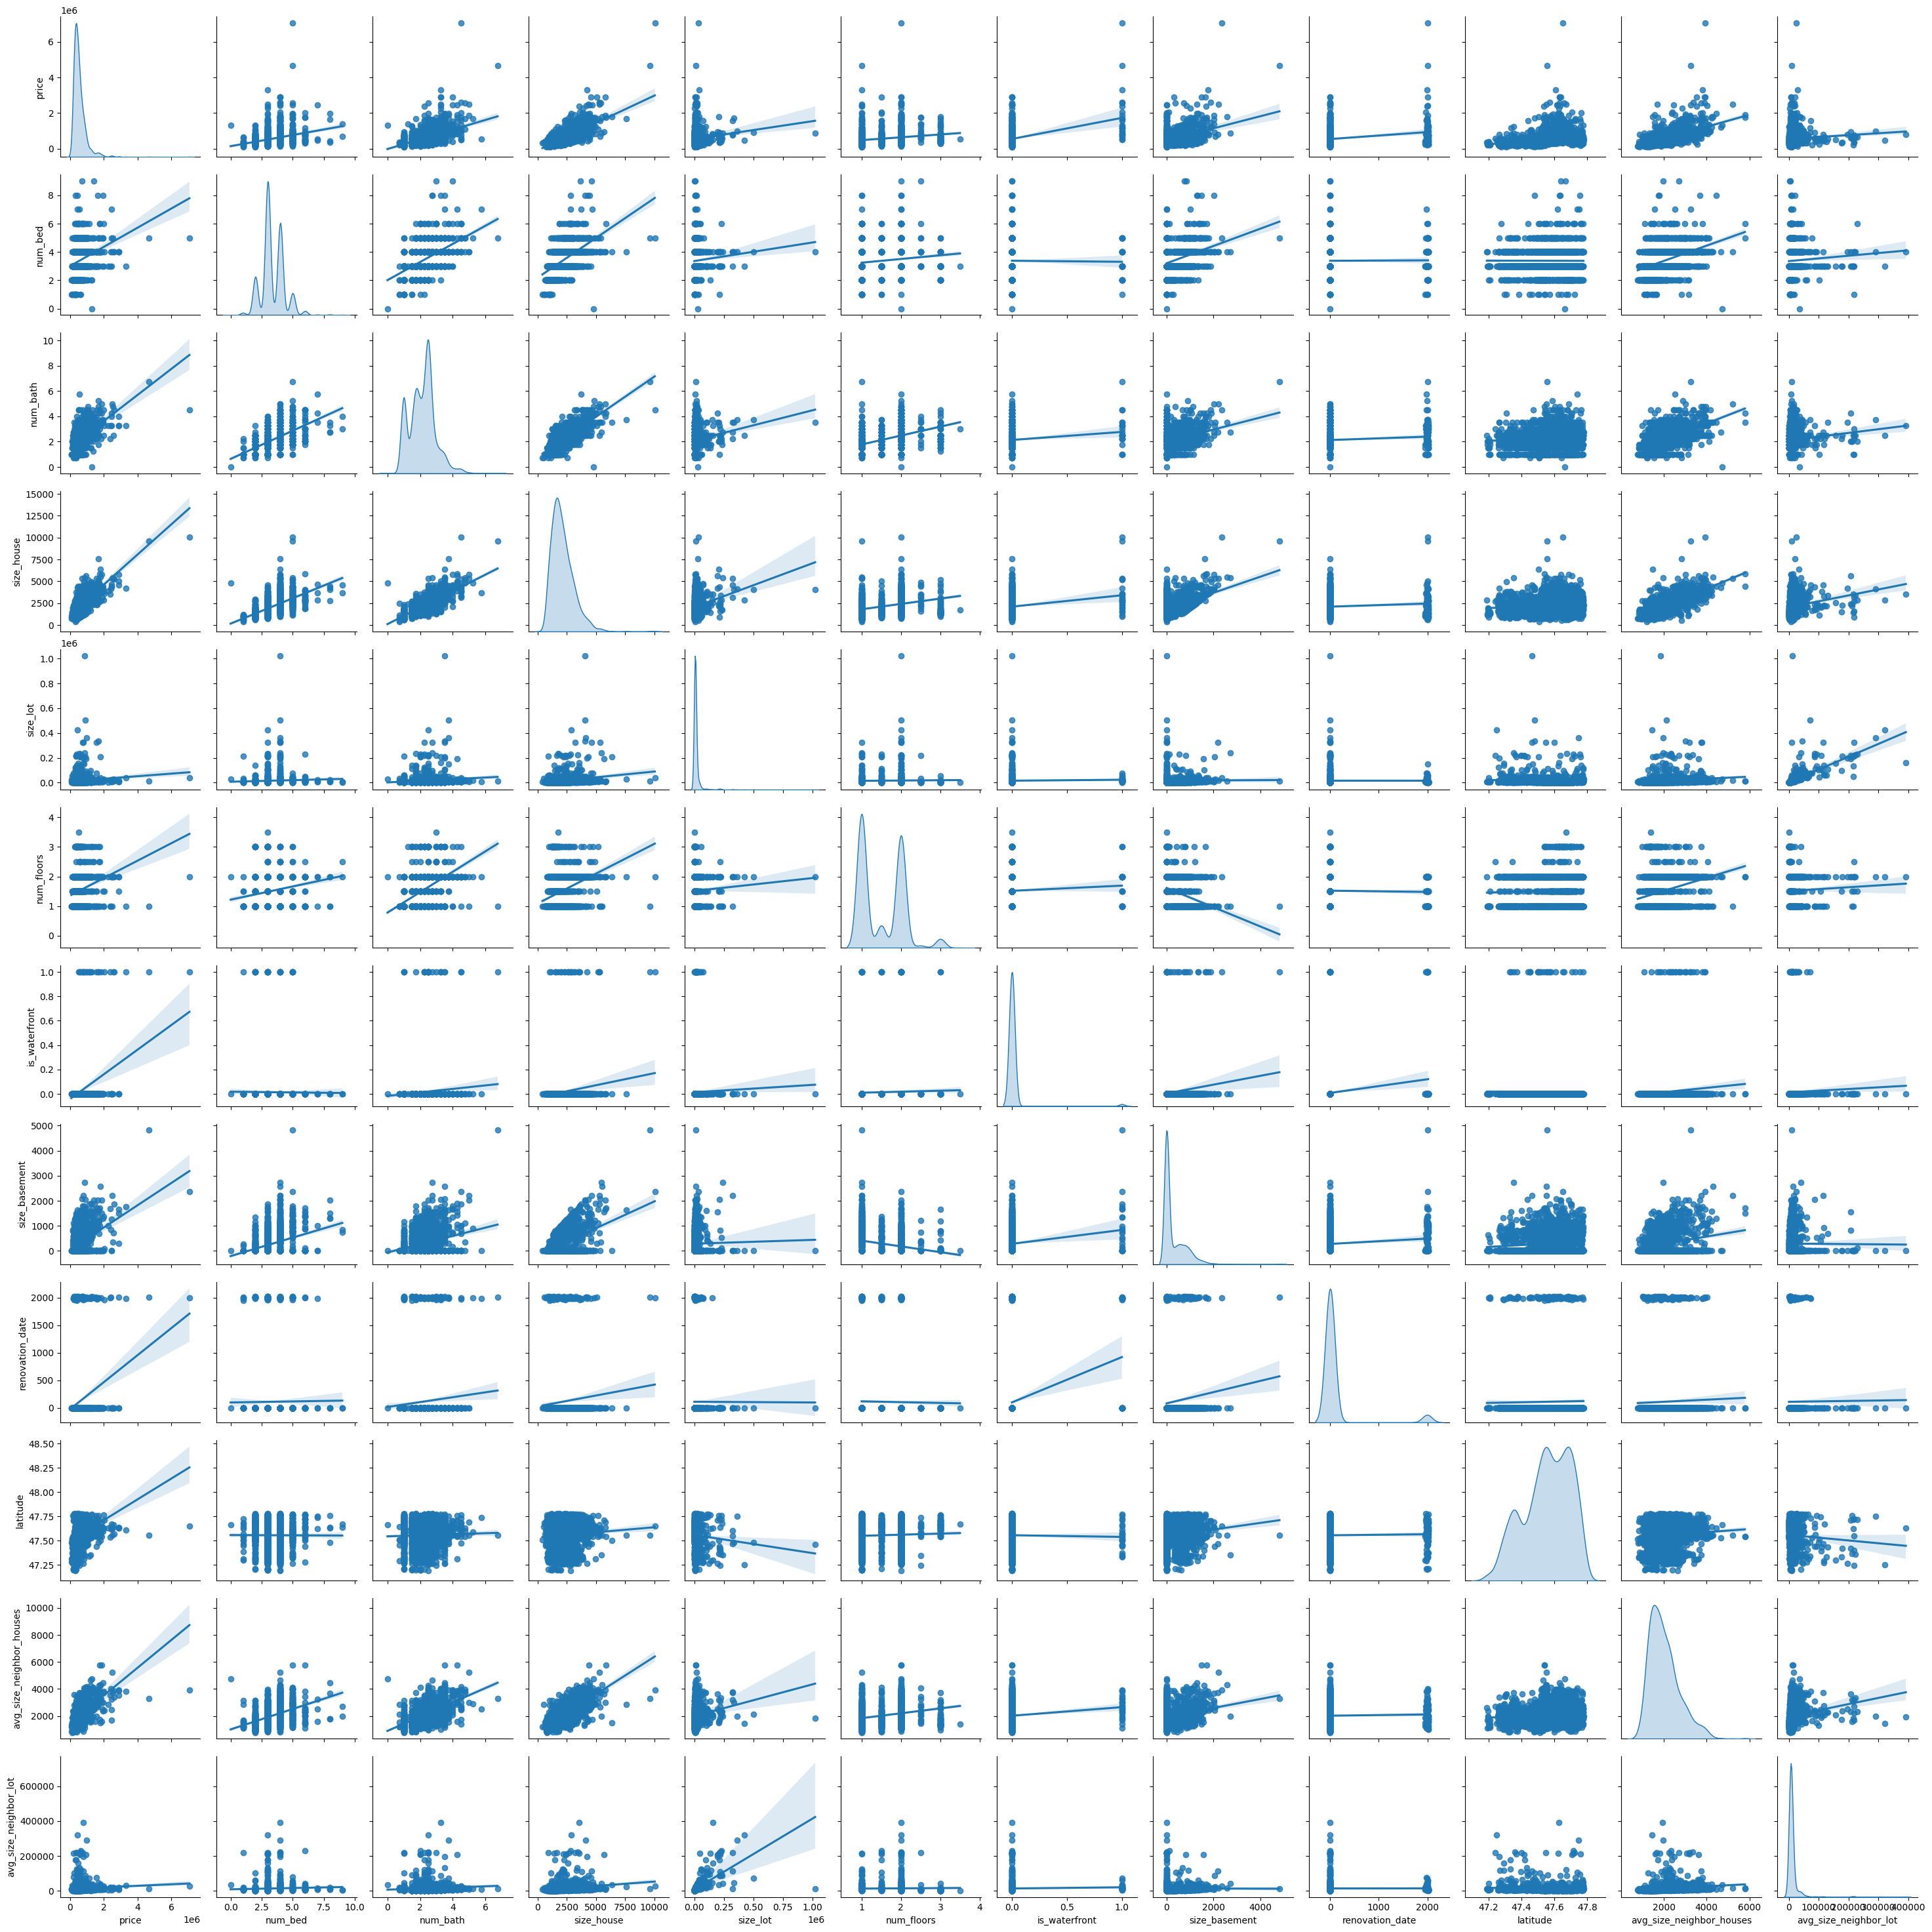

In [26]:
sns.pairplot(df[remaining_features], diag_kind='kde', kind='reg')
plt.show()

# Feature Engineering

## Train test split

In [27]:
df_train_houses, df_test_houses = train_test_split(df, train_size=0.7, random_state=123)

# Predictive Model

## Multiple Linear Regression

For the multiple linear regression model, the selected features will be evaluated based on the following criteria:

- Multicollinearity
- Homoscedasticity of residuals
- Autocorrelation of residuals
- Mean of residuals close to 0
- F-statistic
- P-values
- MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error), MSE (Mean Squared Error), R² (R-squared)

### Multicollinearity

Multicollinearity occurs when two or more independent variables (features) in a dataframe have a high correlation (+1.0 or -1.0) with one another in a regression model. This can lead to unstable and unreliable coefficient estimates, making it harder to interpret the results and draw meaningful conclusions from the model.

One of the methods to detect multicollinearity in a dataset, is Variance Inflation Factor (VIF). The VIF score of an independent variable represents how well the variable is explained by other independent variables.

R^2 value is determined to find out how well an independent variable is described by the other independent variables. A high value of R^2 means that the variable is highly correlated with the other variables. This is captured by the VIF, which is denoted below:

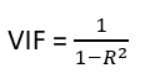

So, the closer the R^2 value to 1, the higher the value of VIF and the higher the multicollinearity with the particular independent variable.

- VIF starts at 1 and has no upper limit;
- VIF = 1, no correlation between the independent variable and the other variables;
- VIF exceeding 13 indicates high multicollinearity between this independent variable and the others.

In [28]:
def vif_score(df, features):
    '''
    Function to determine the VIF Score of independent variables.

    Args
    df: train dataframe.
    features: independent variables of train dataframe.
    '''

    vif_data = pd.DataFrame()
    vif_data["feature"] = df.loc[:,features].columns

    vif_data["VIF"] = [variance_inflation_factor(df.loc[:,features].values, i) for i in range(len(df.loc[:,features].columns))]
    return vif_data.sort_values(by='VIF', ascending=False)

In [29]:
cols_x = remaining_features.copy()
cols_x.remove('price')
vif_score(df_train_houses, cols_x)

,feature,VIF
2,size_house,30.574415
1,num_bath,26.380299
8,latitude,24.602131
9,avg_size_neighbor_houses,22.653031
0,num_bed,22.255584
4,num_floors,16.666653
10,avg_size_neighbor_lot,2.890598
3,size_lot,2.870472
6,size_basement,2.530765
7,renovation_date,1.126630


In [30]:
#dropping feature size_house e re-evaluating VIF
cols_x = remaining_features.copy()
cols_x.remove('price')
cols_x.remove('size_house')
vif_score(df_train_houses, cols_x)

,feature,VIF
1,num_bath,22.238395
7,latitude,20.896502
0,num_bed,20.888994
3,num_floors,16.004057
8,avg_size_neighbor_houses,14.566440
9,avg_size_neighbor_lot,2.889737
2,size_lot,2.776490
5,size_basement,2.103883
6,renovation_date,1.125685
4,is_waterfront,1.089251


In [31]:
#dropping feature num_bath e re-evaluating VIF
cols_x = remaining_features.copy()
cols_x.remove('price')
cols_x.remove('size_house')
cols_x.remove('num_bath')
vif_score(df_train_houses, cols_x)

,feature,VIF
6,latitude,20.173205
0,num_bed,17.598104
7,avg_size_neighbor_houses,12.944904
2,num_floors,11.267495
8,avg_size_neighbor_lot,2.888236
1,size_lot,2.767090
4,size_basement,1.889430
5,renovation_date,1.124240
3,is_waterfront,1.089242


In [32]:
#dropping feature latitude e re-evaluating VIF
cols_x = remaining_features.copy()
cols_x.remove('price')
cols_x.remove('size_house')
cols_x.remove('num_bath')
cols_x.remove('latitude')
vif_score(df_train_houses, cols_x)

,feature,VIF
0,num_bed,12.275587
6,avg_size_neighbor_houses,12.253673
2,num_floors,9.524314
7,avg_size_neighbor_lot,2.886673
1,size_lot,2.765391
4,size_basement,1.889208
5,renovation_date,1.120684
3,is_waterfront,1.086522


Now all features have a VIF < 13.

### Linear Regression #01 with features having VIF < 13.

In [33]:
X_train = df_train_houses[cols_x]
X_train = sm.add_constant(X_train)
y_train = df_train_houses['price']
mdl_lr = sm.OLS(y_train, X_train)
mdl_lr = mdl_lr.fit()

X_test = df_test_houses[cols_x]
X_test = sm.add_constant(X_test)
y_test = df_test_houses['price']

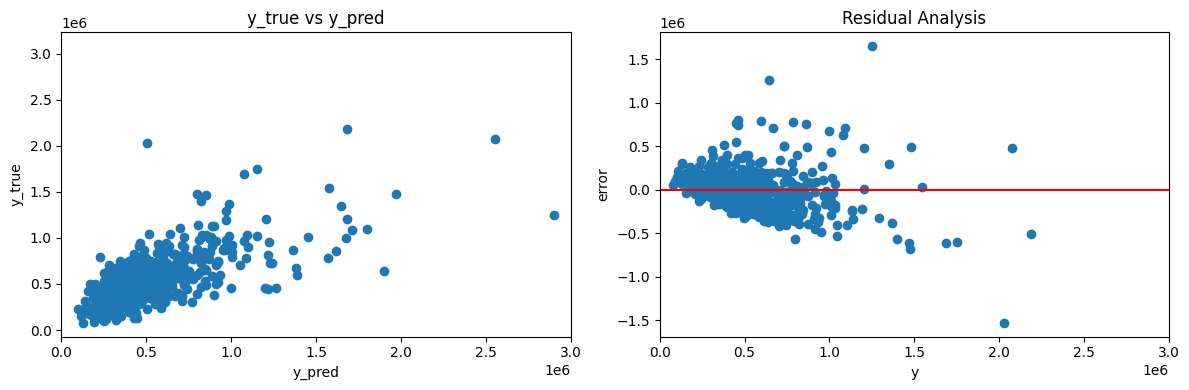

R2: 0.5307
MSE: 64365474438.6
RMSE: 253703.5
MAE: 172942.7
MAPE: 0.3575


In [34]:
y_pred_mdl_lr = mdl_lr.predict(X_test)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(x = y_test, y = y_pred_mdl_lr)
axs[0].set_title('y_true vs y_pred')
axs[0].set_xlim(0, 3e6)
axs[0].set_xlabel('y_pred')
axs[0].set_ylabel('y_true')

y_pred_mdl_lr = mdl_lr.predict(X_test)
error = (y_test - y_pred_mdl_lr)

axs[1].scatter(x = np.round(y_pred_mdl_lr,2), y = error)
axs[1].set_title('Residual Analysis')
axs[1].set_xlim(0, 3e6)
axs[1].axhline(0, color='r')
axs[1].set_xlabel('y')
axs[1].set_ylabel('error')

plt.tight_layout()
plt.show()

# Metrics
print(f'R2: {np.round(r2_score(y_test, y_pred_mdl_lr),4)}')
print(f'MSE: {np.round(mean_squared_error(y_test, y_pred_mdl_lr),1)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(y_test, y_pred_mdl_lr)),1)}')
print(f'MAE: {np.round(mean_absolute_error(y_test, y_pred_mdl_lr),1)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(y_test, y_pred_mdl_lr),4)}')

#### Heteroscedasticity

From the Residual Analysis plot above, it is possible to observe the presence of heteroscedasticity (also spelled heteroskedasticity), indicating that some pattern was not identified by the linear model.

Heteroscedasticity refers to situations where the variance of the residuals is unequal over a range of measured values. When running a regression involving ordinary least squares (OLS), heteroscedasticity results in an unequal scatter of the residuals. In statistics, this is seen as a problem because these type of regressions assumes that the residuals are drawn from a population with constant variance. So, if there is an unequal scatter of residuals, the population used in the regression contains unequal variance, and therefore the analysis results may be invalid.

A common explanation that causes heteroscedaasticity is that the error variance changes proportionally with a factor. This factor might be a variable in the model.

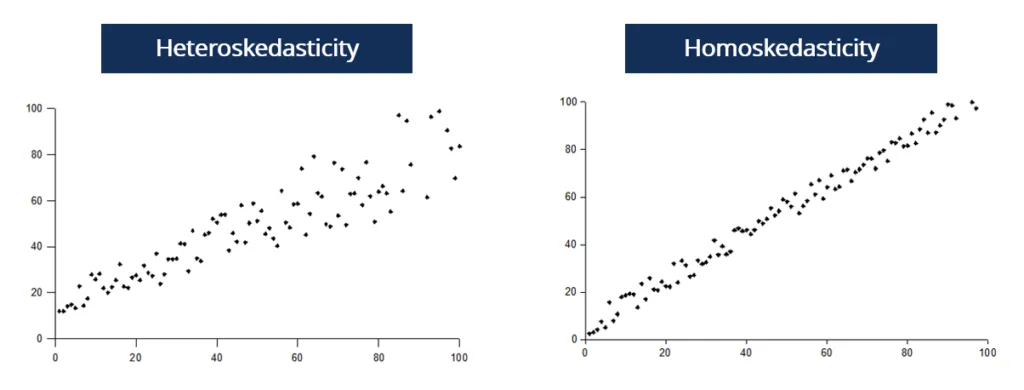

There is two types of heteroscedasticity:

- Pure heteroscedasticity: Refers to cases where the correct model is specified and yet non-constant variance is observed in the residual plots.

- Impure heteroscedasticity: Refers to cases where the model is incorrectly specified, causing the non-constant variance. When an important variable is left out of a model, the omitted effect is absorbed into the error term.

There is three aproaches to fix this problem:

- Redefining the variables: Trying to specify the model to reduce the impact of the size differential. To achieve this, changing the model from using the raw measure to using rates and per capita values.

- Weighted regression: This is a method that assigns each data point a weight based on the variance of its fitted value. The idea is to give small weights to observations associated with higher variances to minimize their squared residuals.

- Transform the dependent variable: Transforming the original data into different values that produces good looking residuals.

#### Autocorrelation of residuals

Autocorrelation can be of nature positive or negative and if exists, it undervalues the standard error causing us to believe that predictors are significant when in reality they are not.

The Durbin Watson (DW) statistic is used as a test for checking auto correlation in the residuals of a statistical regression analysis. The Durbin-Watson statistic will always have a value ranging between 0 and 4.

- Values from 2 to 4 means negative autocorrelation;
- A value of 2.0 indicates there is no autocorrelation detected in the sample;
- Values from 0 to less than 2 point to positive autocorrelation.

In [35]:
print(mdl_lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     172.0
Date:                Wed, 15 May 2024   Prob (F-statistic):          5.90e-197
Time:                        16:32:28   Log-Likelihood:                -18065.
No. Observations:                1291   AIC:                         3.615e+04
Df Residuals:                    1282   BIC:                         3.619e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Since the Durbin-Watson value is near 2.0, there is no autocorrelation detected.

#### F-Statistic

The F-statistic is based on the ratio of two variances: the explained variance (due to the model) and the unexplained variance (residuals). The F-statistic compares the explained variance (due to the model) and the unexplained variance (residuals). By comparing these variances, the F-statistic helps us determine whether the regression model significantly explains the variation in the dependent variable or whether the variation can be attributed to chance.

- A higher F-statistic may indicate that the model accounts for a substantial portion of the total variance;
- A lower F-statistic suggests that the model may not explain much of the variance and therefore may not be seen as a useful model.

The F-statistic is calculated from the following formula:

f = MSR / MSE

= Mean Regression Sum of Squares / Mean Error Sum of Squares

The F-statistic follows an F-distribution, and its value helps determine the probability (p-value) of observing such a statistic if the null hypothesis is true (i.e., no relationship between the dependent and independent variables). If the p-value is less than a predetermined significance level (e.g., 0.05), the null hypothesis is rejected, and we conclude that the regression model is statistically significant.

Since the F-statistic value is low, this indicates that the regression is valid.

#### P-value

P-values (or probability values) are used in hypothesis testing to represent the chance that, assuming the null hypothesis is true.

Features with a p-value > 0.05 indicate that the calculated coefficient is not statistically significant, and therefore it is recommended to remove them.

It can be observed that even after removing features with high VIF in the model, the num_bed feature was the only one to still have a high p-value. Therefore, this feature will be dropped now.

In [36]:
#dropping feature latitude e re-evaluating VIF
cols_x = remaining_features.copy()
cols_x.remove('price')
cols_x.remove('size_house')
cols_x.remove('num_bath')
cols_x.remove('latitude')
cols_x.remove('num_bed')
vif_score(df_train_houses, cols_x)

,feature,VIF
5,avg_size_neighbor_houses,9.336219
1,num_floors,7.390316
6,avg_size_neighbor_lot,2.883157
0,size_lot,2.764478
3,size_basement,1.707851
4,renovation_date,1.120334
2,is_waterfront,1.080286


In [37]:
X_train = df_train_houses[cols_x]
X_train = sm.add_constant(X_train)
y_train = df_train_houses['price']

mdl_lr = sm.OLS(y_train, X_train)
mdl_lr = mdl_lr.fit()

In [38]:
print(mdl_lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     196.8
Date:                Wed, 15 May 2024   Prob (F-statistic):          4.07e-198
Time:                        16:32:28   Log-Likelihood:                -18065.
No. Observations:                1291   AIC:                         3.615e+04
Df Residuals:                    1283   BIC:                         3.619e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Now, all the remaining features have a p-value < 0.05, so all of them will be retained.

### Linear Regression #02 transforming dependent variable to obtain Normal Distribution

### Test of Normality

Shapiro-Wilk test is a hypothesis test that evaluates whether a dataset is normally distributed. It evaluates data from a sample with:

- H0: Indicates that the dataset is normally distributed. So there is no statistically significant difference between the observed distribution and the theoretical normal distribution.
- H1: Indicates that the dataset is not normally distributed.

P-value:
- A large p-value indicates the dataset is normally distributed
- A low p-value indicates that it isn’t normally distributed.

In [41]:
# Shapiro-Wilk Test
def shapiro_test(data, alpha=0.05):
    stat, p = shapiro(data)
    print('p-value: p=%.3f' % (p))
    # interpret
    alpha = alpha
    if p > alpha:
        print('The sample appears to be normally distributed Gaussian. We do not reject H0.')
    else:
        print('The sample does not appear to be normally distributed Gaussian. We reject H0.')
    return stat, p